In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
def parse_report(report_dir):
    with open(report_dir + "parameters.json") as f:
        parameters = json.load(f)
    report = pd.read_csv(report_dir + "report.csv")
    report['day'] = report['time_step'] / parameters['time_steps_per_day']
    report = report.set_index('day')
    report.drop('time_step', axis='columns', inplace=True)
    report.rename({
        'num_susceptible': 'Susceptible', 
        'num_presymptomatic': 'Pre-symptomatic', 
        'num_infected': 'Infected', 
        'num_recovered': 'Recovered'}, 
        axis='columns', inplace=True)
    return (parameters, report)

In [36]:
def graph_infections(report, title):
    fig, ax = plt.subplots()
    ax.set_ylabel('Number of People')
    ax.set_title(title)
    report.plot(ax=ax)
    return fig

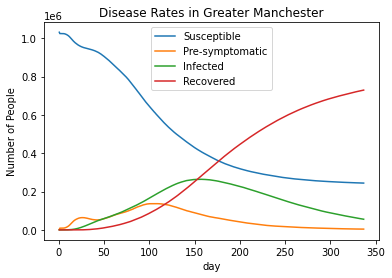

In [38]:
parameters, report = parse_report("../../reports/greater_manchester/0/")
fig = graph_infections(report, 'Disease Rates in Greater Manchester')
fig.savefig('graphs/greater_manchester')

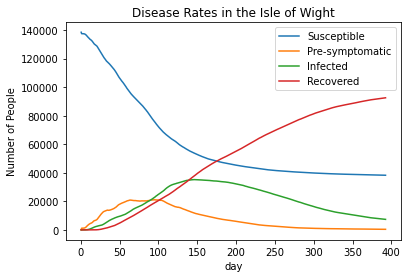

In [40]:
parameters, report = parse_report("../../reports/isle_of_wight/1/")
graph_infections(report, 'Disease Rates in the Isle of Wight')
fig.savefig('graphs/isle_of_wight')

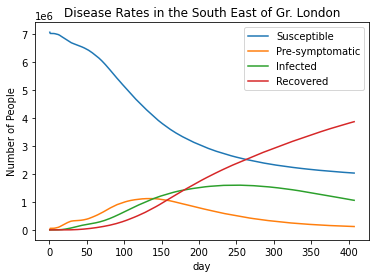

In [46]:
parameters, report = parse_report("../../reports/london_se_commuter_ring/0/")
fig = graph_infections(report, 'Disease Rates in the South East of Gr. London')
fig.savefig('graphs/london_se_commuter_ring')